# Programming Assignment

**Warning**:

Please modify only the code that is between
```Python
### YOUR CODE HERE ###
```
and
```Python
### ^^^^^^^^^^^^^^ ###
```
Some of the cells to be completed by the student are followed by a "check" cell that performs some basic unit tests. Run them after completing the code to check your results. Their only purpose is to help the student and will not be used to evaluate the assignment.

# Building a Bag of Words Model

Let's build a basic BoW model for a text classification problem with the [20 newsgroups](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_20newsgroups.html) dataset.

In [1]:
from sklearn.datasets import fetch_20newsgroups

X, y = fetch_20newsgroups(return_X_y=True, subset="all")

Using scikit-learn, create a pipeline consisting of a TF-IDF vectorization with 1-, 2- and 3-grams, and a Random Forest with 100 trees of max depth of 4. Evaluate it's f1-macro score with a 3-fold cross-validation:

F1 Macro Scores: [0.51271475 0.47980077 0.45769623]
Mean F1 Macro Score: 0.4834039133437245
              precision    recall  f1-score   support

           0       0.86      0.42      0.57       151
           1       0.65      0.35      0.46       202
           2       0.83      0.05      0.10       195
           3       0.48      0.22      0.30       183
           4       0.88      0.15      0.25       205
           5       0.93      0.36      0.52       215
           6       0.71      0.65      0.68       193
           7       0.80      0.27      0.40       196
           8       0.10      0.86      0.18       168
           9       0.88      0.49      0.63       211
          10       0.48      0.84      0.62       198
          11       0.83      0.79      0.81       201
          12       0.80      0.18      0.30       202
          13       0.90      0.32      0.48       194
          14       0.65      0.88      0.75       189
          15       0.50      0.63      0.56

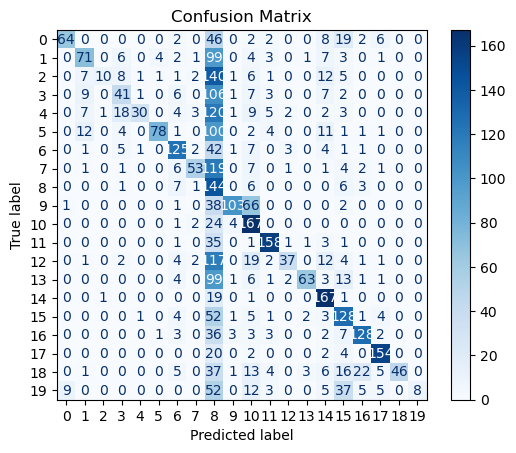

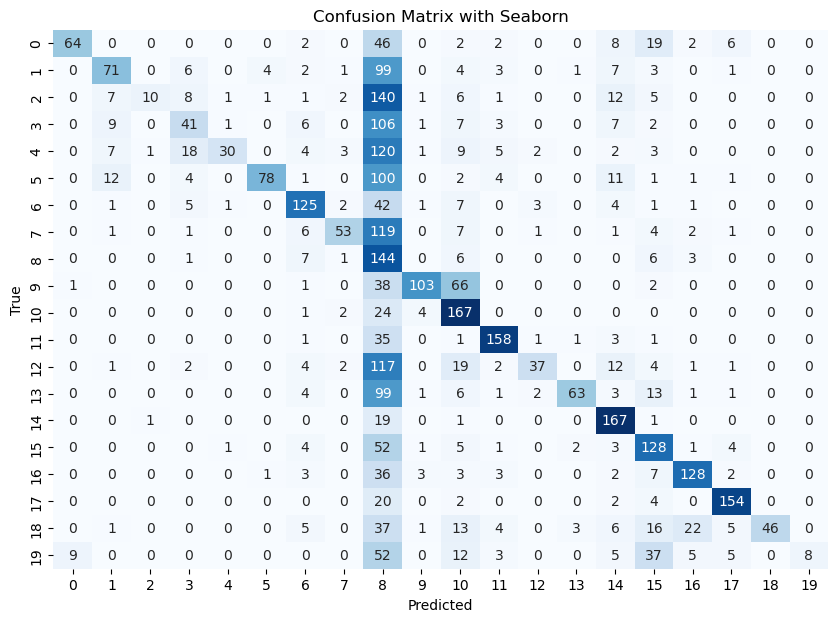

In [2]:
#Using scikit-learn, create a pipeline consisting of a TF-IDF vectorization with 1-, 2- and 3-grams
#and a Random Forest with 100 trees of max depth of 4.
# Evaluate it's f1-macro score with a 3-fold cross-validation
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import make_scorer, f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Create a pipeline with TF-IDF and Random Forest
pipeline = make_pipeline(
    TfidfVectorizer(ngram_range=(1, 3)),
    RandomForestClassifier(n_estimators=100, max_depth=4, random_state=42)
)
# Perform 3-fold cross-validation
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
f1_macro_scorer = make_scorer(f1_score, average='macro')
f1_scores = cross_val_score(pipeline, X, y, cv=cv, scoring=f1_macro_scorer)
print(f"F1 Macro Scores: {f1_scores}")
print(f"Mean F1 Macro Score: {np.mean(f1_scores)}")

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)
# Make predictions on the test data
y_pred = pipeline.predict(X_test)
# Print classification report
print(classification_report(y_test, y_pred))
# Print confusion matrix
cm = confusion_matrix(y_test, y_pred)
cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=pipeline.classes_)
cm_display.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()
# Plot confusion matrix with seaborn
df_cm = pd.DataFrame(cm, index=pipeline.classes_, columns=pipeline.classes_)
plt.figure(figsize=(10, 7))
sns.heatmap(df_cm, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title("Confusion Matrix with Seaborn")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()



In [3]:
### YOUR CODE HERE ###
...
### ^^^^^^^^^^^^^^ ###

# Building a Recurrent Neural Network

<a name='0'></a>
## Notation

- Subscript $n$ denotes the $n^{th}$ sample. 

- Superscript $[l]$ denotes the $l^{th}$ layer. 

- Superscript $\langle t \rangle$ denotes the $t^{th}$ time step. 
    
- Subscript $(d)$ denotes the $d^{th}$ entry of a vector.

**Example**:

$z^{[2]<3>}_{1(4)}$ denotes the activation of the 1st training sample, [2]nd layer, <3>rd time step, and (4)th entry in the vector.

<a name='1'></a>
## 1 - Recurrent Neural Network (RNN)

### Input $x$

* A training sample $x_n$ consists of multiple time steps $T_{x_n}$. Let's assume $T_x$ be the number of timesteps in the longest $x_n$.
* A time step of an input sample, $x^{\langle t \rangle }_n$, is a one-dimensional input vector of size $n_x$. For example, a 1000-word vocabulary/dictionary would be encoded as a collection of one-hot vectors of size $n_x=D$ of 1000, and word $x_n^{\langle t \rangle}$ would have shape (1000,).
* Let's use mini-batches of size $m$ of $x_n$ samples to benefit from vectorization. The shape of one such batch will be $(n_x,m,T_x)$. For example, if mini-batches of size 10 are used, the resulting 3D tensor will be (5000,20,10)-shaped.
* For each time step $t$, a 2D slice $x^{\langle t \rangle}$ of shape $(n_x,m)$ will be fed into the network.

### Hidden state $z$

* The shape of a mini-batch of hidden states is $(n_z,m,T_x)$ including the time step dimension, with $n_z$ the number of hidden units.
* $z^{\langle t \rangle}$ is a 2D slice at timestep $t$ of this minibatch, and has a shape of $(n_z, m)$.

### Output $\hat{y}$
* $\hat{y}$ is a 3D tensor of shape $(n_y,m,T_y)$, with $n_{y}$ the number of units in the vector representing the prediction and $T_{y}$ the number of time steps in the prediction. Lets assume $T_y = T_x$.
* $\hat{y}^{\langle t \rangle}$ is a 2D slice for time step $t$ and has a shape of $(n_{y}, m)$.

<a name='1-1'></a>
### 1.1 - RNN Cell

Let's start by implementing the computations for a single time step of the RNN cell.

**Instructions**:
1. Compute the hidden state: $z^{\langle t \rangle} = \tanh(W_z z^{\langle t-1 \rangle} + W_x x^{\langle t \rangle} + b)$. Use [numpy.tanh](https://numpy.org/devdocs/reference/generated/numpy.tanh.html) and [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html).
2. Use hidden state $z^{\langle t \rangle}$ to compute the prediction $\hat{y}^{\langle t \rangle} = softmax(W_y z^{\langle t \rangle} + b_y)$. Use the provided `softmax` function.
4. Return $z^{\langle t \rangle}$ , $\hat{y}^{\langle t \rangle}$

In [4]:
import numpy as np

def softmax(x):
  expon = np.exp(x)
  return expon/np.sum(expon)

def rnn_cell(x, z, Wx, Wy, Wz, b, by):
    """
    Single step of the RNN cell.

    Arguments:
        x: input data at timestep "t", numpy array of shape (n_x,m).
        z: hidden state at timestep "t-1", numpy array of shape (n_z,m)
        Wx: weight matrix multiplying the input, numpy array of shape (n_z,n_x)
        Wy: weight matrix relating the hidden-state to the output, numpy array of shape (n_y,n_z)
        Wz: weight matrix multiplying the hidden state, numpy array of shape (n_z,n_z)
        b: bias, numpy array of shape (n_z,1)
        by: bias relating the hidden-state to the output, numpy array of shape (n_y,1)
    Returns:
        z: hidden state at timestep "t", of shape (n_z,m)
        y_pred: prediction at timestep "t", numpy array of shape (n_y,m)
    """
    ### YOUR CODE HERE ###
    # Compute the new hidden state
    z = np.tanh(np.dot(Wx, x) + np.dot(Wz, z) + b)
    # Compute the output        
    y_pred = np.dot(Wy, z) + by
    # Apply softmax to the output
    y_pred = softmax(y_pred)
    ### ^^^^^^^^^^^^^^ ###
        
    return z, y_pred

In [5]:
# Check

np.random.seed(1)
x = np.random.randn(3, 10)
z = np.random.randn(5, 10)
Wx = np.random.randn(5, 3)
Wz = np.random.randn(5, 5)
Wy = np.random.randn(2, 5)
b = np.random.randn(5, 1)
by = np.random.randn(2, 1)
z, y_pred = rnn_cell(x, z, Wx, Wy, Wz, b, by)

np.testing.assert_equal(z.shape, (5, 10))
expected_z4 = np.array([-0.97683053, 0.99993218, 0.9999085, 0.99720415, 0.96532437, 0.24615069, 0.89433073, 0.88371261, 0.40821569, -0.99446565])
np.testing.assert_allclose(z[4], expected_z4, rtol=1e-2)
np.testing.assert_equal(y_pred.shape, (2, 10))
expected_y_pred1 = np.array([0.00402888, 0.03824577, 0.03569951, 0.07060504, 0.01322519, 0.03128045, 0.02207267, 0.25945201, 0.03835635, 0.00209625])
np.testing.assert_allclose(y_pred[1], expected_y_pred1, rtol=1e-2)

In [6]:
print(expected_z4)

[-0.97683053  0.99993218  0.9999085   0.99720415  0.96532437  0.24615069
  0.89433073  0.88371261  0.40821569 -0.99446565]


In [7]:
print(expected_y_pred1)

[0.00402888 0.03824577 0.03569951 0.07060504 0.01322519 0.03128045
 0.02207267 0.25945201 0.03835635 0.00209625]


<a name='1-2'></a>
### 1.2 - RNN Forward Propagation 

A recurrent neural network can now be implemented as the repeated use of a cell. If the input sequence is $T_x$ time steps long, the RNN cell will be called $T_x$ times.

- The cell takes two inputs at each time step:
    - $z^{\langle t-1 \rangle}$: the hidden state from the previous time step
    - $x^{\langle t \rangle}$: the current time step's input data
- The cell produces two outputs at each time step:
    - $z^{\langle t \rangle}$: the hidden state at this time step
    - $\hat{y}^{\langle t \rangle}$: the prediction for this time step
- The weights and biases $(W_z, W_x, b)$ are re-used each time step 

**Instructions**:

At each time step $t$:
1. Get $x^{\langle t \rangle}$, the 2D slice of $x$ at time step $t$.
2. Update the 2D hidden state $z^{\langle t \rangle}$ and the prediction $\hat{y}^{\langle t \rangle}$ using `rnn_cell`.
3. Store the 2D hidden state in the 3D tensor $z$, at the $t^{th}$ position.
4. Store the 2D $\hat{y}^{\langle t \rangle}$ prediction in the 3D tensor $\hat{y}$ at the $t^{th}$ position.
5. Return the 3D tensors $z$ and $\hat{y}$.

In [8]:
def rnn_forward(x, z, Wx, Wy, Wz, b, by):
    """
    Forward propagation of the RNN.

    Arguments:
        x: input data for every time-step, of shape (n_x,m,T_x).
        z: initial hidden state, of shape (n_z,m)
        Wx: weight matrix multiplying the input, numpy array of shape (n_z,n_x)
        Wy: weight matrix relating the hidden-state to the output, numpy array of shape (n_y,n_z)
        Wz: weight matrix multiplying the hidden state, numpy array of shape (n_z,n_z)
        b: bias numpy array of shape (n_z,1)
        by: bias relating the hidden-state to the output, numpy array of shape (n_y,1)
    Returns:
        z: hidden states for every time-step, numpy array of shape (n_z,m,T_x)
        y_pred: predictions for every time-step, numpy array of shape (n_y,m,T_x)
    """
    
    # Retrieve dimensions and initialize z, y_pred and zt
    n_x, m, T_x = x.shape
    n_y, n_z = Wy.shape
    zt = z
    z = np.zeros((n_z, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))
    
    # loop over time steps
    for t in range(T_x):
        ### YOUR CODE HERE ###
        # Update the hidden state and compute the prediction with rnn_cell
        zt, yt_pred = rnn_cell(x[:,:,t], zt, Wx, Wy, Wz, b, by)
        # Save the value of the hidden state at time step t in z
        z[:,:,t] = zt   
        # Save the value of the prediction at time step t in y_pred
        y_pred[:,:,t] = yt_pred
        ### ^^^^^^^^^^^^^^ ###
    
    return z, y_pred

In [9]:
# Check

np.random.seed(1)
x = np.random.randn(3, 10, 4)
z = np.random.randn(5, 10)
Wz = np.random.randn(5, 5)
Wx = np.random.randn(5, 3)
Wy = np.random.randn(2, 5)
b = np.random.randn(5, 1)
by = np.random.randn(2, 1)
z, y_pred = rnn_forward(x, z, Wx, Wy, Wz, b, by)

np.testing.assert_equal(z.shape, (5, 10, 4))
expected_z4 = np.array([-0.99999375, 0.77911235, -0.99861469, -0.99833267])
np.testing.assert_allclose(z[4][1], expected_z4, rtol=1e-2)
np.testing.assert_equal(y_pred.shape, (2, 10, 4))
expected_y_pred1 = np.array([0.01644489, 0.0328586, 0.0014877, 0.02851197])
np.testing.assert_allclose(y_pred[1][3], expected_y_pred1, rtol=1e-2)

In [10]:
print(expected_z4)

[-0.99999375  0.77911235 -0.99861469 -0.99833267]


In [11]:
print(expected_y_pred1)

[0.01644489 0.0328586  0.0014877  0.02851197]


<a name='2'></a>
## 2 - Long Short-Term Memory (LSTM)

The RNN works best when each output $\hat{y}^{\langle t \rangle}$ can be estimated using "local" context, but suffers from vanishing gradient and cannot remember information for many time steps. LSTM can cope with vanishing gradient much better.

Let's begin by implementing the LSTM cell for a single time step. Then, it will be possible to call it from a loop to have it process an input with $T_x$ time steps.

### Gates and states

#### Forget gate $f$

The forget gate is a tensor containing values between 0 and 1.
    * If a unit in the forget gate has a value close to 0, the LSTM will "forget" the stored previous state in the corresponding unit.
    * If a unit in the forget gate has a value close to 1, the LSTM will "remember" the the stored previous state in the corresponding unit.

$$f^{\langle t \rangle} = \sigma(\mathbf{W}_f[\mathbf{h}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_f)$$

#### Candidate cell value $\tilde{\mathbf{c}}^{\langle t \rangle}$
* The candidate cell value is a tensor containing information from the current time step that may be stored in the current cell state $\mathbf{c}^{\langle t \rangle}$.
* The parts of the candidate cell value that get passed on depend on the input gate.
* The candidate cell value is a tensor containing values that range from -1 to 1.

$$\mathbf{\tilde{c}}^{\langle t \rangle} = \tanh\left( \mathbf{W}_{c} [\mathbf{h}^{\langle t - 1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{c} \right)$$

#### Input gate $i$

* The input gate decides what entries of the candidate cell value $\tilde{\mathbf{c}}^{\langle t \rangle}$ to add to the cell state $c^{\langle t \rangle}$.
* The update gate is a tensor containing values between 0 and 1.
    * When a unit in the update gate is close to 1, it allows the value of the candidate $\tilde{\mathbf{c}}^{\langle t \rangle}$ to be passed onto the hidden state $\mathbf{c}^{\langle t \rangle}$
    * When a unit in the update gate is close to 0, it prevents the corresponding value in the candidate from being passed onto the hidden state.

$$i^{\langle t \rangle} = \sigma(\mathbf{W}_i[h^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_i)\tag{2}$$

#### Cell state $\mathbf{c}^{\langle t \rangle}$

* The cell state is the "memory" passed to future time steps.
* The new cell state $\mathbf{c}^{\langle t \rangle}$ is a combination of the previous cell state and the candidate value.

$$\mathbf{c}^{\langle t \rangle} = f^{\langle t \rangle}*\mathbf{c}^{\langle t-1 \rangle} + i^{\langle t \rangle}*\mathbf{\tilde{c}}^{\langle t \rangle}$$

#### Output gate $o$

* The output gate decides what gets sent as the output (prediction) of the time step.
* The output gate contains values that range from 0 to 1.

$$o^{\langle t \rangle}= \sigma(\mathbf{W}_o[\mathbf{h}^{\langle t-1 \rangle}, \mathbf{x}^{\langle t \rangle}] + \mathbf{b}_{o})$$ 


#### Hidden state $\mathbf{h}^{\langle t \rangle}$

* The hidden state gets passed to the LSTM cell's next time step.
* It is used to determine the three gates ($f, i, o$) of the next time step.
* The hidden state is also used for the prediction $y^{\langle t \rangle}$.

$$ \mathbf{h}^{\langle t \rangle} = o^{\langle t \rangle}*\tanh(\mathbf{c}^{\langle t \rangle})$$


#### Prediction $\mathbf{y}^{\langle t \rangle}_{pred}$

* The output or prediction.

If the problem is multiclass classification (therefore with a softmax activation at the output), for example, the equation would be:
$$\mathbf{y}^{\langle t \rangle}_{pred} = \textrm{softmax}(\mathbf{W}_{y} \mathbf{h}^{\langle t \rangle} + \mathbf{b}_{y})$$

<a name='2-1'></a>
### 2.1 - LSTM Cell

Lets implement the LSTM cell.

**Instructions**:
1. Compute all formulas for the gates and states. Use [numpy.tanh](https://docs.scipy.org/doc/numpy/reference/generated/numpy.tanh.html) and [numpy.dot](https://docs.scipy.org/doc/numpy/reference/generated/numpy.dot.html) and the provided functions `sigmoid` and `softmax`.
2. Compute the prediction $y^{\langle t \rangle}$.

In [12]:
def sigmoid(x):
  return 1/(1 + np.exp(-x))

def lstm_cell(x, h, c, Wf, bf, Wi, bi, Wc, bc, Wo, bo, Wy, by):
    """
    Single step of the LSTM cell.

    Arguments:
        x: your input data at timestep "t", numpy array of shape (n_x,m).
        h: hidden state at timestep "t-1", numpy array of shape (n_h,m).
        c: memory state at timestep "t-1", numpy array of shape (n_h,m).
        Wf: weight matrix of the forget gate, numpy array of shape (n_h,n_h + n_x).
        bf: bias of the forget gate, numpy array of shape (n_h,1).
        Wi: weight matrix of the input gate, numpy array of shape (n_h,n_h + n_x).
        bi: bias of the input gate, numpy array of shape (n_h,1).
        Wc: weight matrix of the first "tanh", numpy array of shape (n_h,n_h + n_x).
        bc: bias of the first "tanh", numpy array of shape (n_h,1).
        Wo: weight matrix of the output gate, numpy array of shape (n_h,n_h + n_x).
        bo: bias of the output gate, numpy array of shape (n_h,1).
        Wy: weight matrix relating the hidden state to the output, numpy array of shape (n_y,n_h).
        by: bias relating the hidden state to the output, numpy array of shape (n_y,1).                    
    Returns:
        h_next: next hidden state, of shape (n_h,m).
        c_next: next memory state, of shape (n_h,m).
        yt_pred: prediction at timestep "t", numpy array of shape (n_y,m).
    """

    # Retrieve dimensions from shapes of x and Wy and concatenate h and x
    n_x, m = x.shape
    n_y, n_h = Wy.shape
    concat = np.concatenate((h, x))

    ### YOUR CODE HERE ###
    # Compute values for f, i, cct, c, o, h using the formulas
    f = sigmoid(Wf @ concat + bf)
    i = sigmoid(Wi @ concat + bi)
    cct = np.tanh(Wc @ concat + bc)
    c = f * c + i * cct
    o = sigmoid(Wo @ concat + bo)
    h = o * np.tanh(c)

    # Compute prediction of the LSTM cell
    y_pred = Wy @ h + by
    # Apply softmax to the output
    y_pred = softmax(y_pred)
    ### ^^^^^^^^^^^^^^ ###

    return h, c, y_pred

In [13]:
# Check

np.random.seed(1)
x = np.random.randn(3, 10)
h = np.random.randn(5, 10)
c = np.random.randn(5, 10)
Wf = np.random.randn(5, 5 + 3)
bf = np.random.randn(5, 1)
Wi = np.random.randn(5, 5 + 3)
bi = np.random.randn(5, 1)
Wo = np.random.randn(5, 5 + 3)
bo = np.random.randn(5, 1)
Wc = np.random.randn(5, 5 + 3)
bc = np.random.randn(5, 1)
Wy = np.random.randn(2, 5)
by = np.random.randn(2, 1)
h, c, y_pred = lstm_cell(x, h, c, Wf, bf, Wi, bi, Wc, bc, Wo, bo, Wy, by)

np.testing.assert_equal(h.shape, (5, 10))
expected_h4 = np.array([-0.66408471, 0.0036921, 0.02088357, 0.22834167, -0.85575339, 0.00138482, 0.76566531, 0.34631421, -0.00215674, 0.43827275])
np.testing.assert_allclose(h[4], expected_h4, rtol=1e-2)
np.testing.assert_equal(c.shape, (5, 10))
expected_c2 = np.array([0.63267805, 1.00570849, 0.35504474, 0.20690913, -1.64566718, 0.11832942, 0.76449811, -0.0981561, -0.74348425, -0.26810932])
np.testing.assert_allclose(c[2], expected_c2, rtol=1e-2)
np.testing.assert_equal(y_pred.shape, (2, 10))
expected_y_pred1 = np.array([0.0283805, 0.00706782, 0.00753306, 0.01091349, 0.02806865, 0.00955958, 0.00444923, 0.01152125, 0.01426974, 0.01237766])
np.testing.assert_allclose(y_pred[1], expected_y_pred1, rtol=1e-2)

In [14]:
print(expected_h4)

[-0.66408471  0.0036921   0.02088357  0.22834167 -0.85575339  0.00138482
  0.76566531  0.34631421 -0.00215674  0.43827275]


In [15]:
print(expected_c2)

[ 0.63267805  1.00570849  0.35504474  0.20690913 -1.64566718  0.11832942
  0.76449811 -0.0981561  -0.74348425 -0.26810932]


In [16]:
print(expected_y_pred1)

[0.0283805  0.00706782 0.00753306 0.01091349 0.02806865 0.00955958
 0.00444923 0.01152125 0.01426974 0.01237766]


<a name='2-2'></a>
### 2.2 - LSTM Forward Propagation

Now it is possible to iterate over the LSTM cell using a for loop to process a sequence of $T_x$ inputs.

**Instructions**:

For each time step:
1. From the 3D tensor $x$, get a 2D slice $x^{\langle t \rangle}$ at time step $t$.
2. Call the `lstm_cell` function to get the hidden state, cell state and prediction.
3. Store the hidden state, cell state and prediction (the 2D tensors) inside the 3D tensors.

In [17]:
def lstm_forward(x, h, Wf, bf, Wi, bi, Wc, bc, Wo, bo, Wy, by):
    """
    Forward propagation of the LSTM network.

    Arguments:
        x: input data for every time step, of shape (n_x,m,T_x).
        h: initial hidden state, of shape (n_h,m).
        Wf: weight matrix of the forget gate, numpy array of shape (n_h,n_h + n_x).
        bf: bias of the forget gate, numpy array of shape (n_h,1).
        Wi: weight matrix of the input gate, numpy array of shape (n_h,n_h + n_x).
        bi: bias of the input gate, numpy array of shape (n_h,1).
        Wc: weight matrix of the first "tanh", numpy array of shape (n_h,n_h + n_x).
        bc: bias of the first "tanh", numpy array of shape (n_h,1).
        Wo: weight matrix of the output gate, numpy array of shape (n_h,n_h + n_x).
        bo: bias of the output gate, numpy array of shape (n_h,1).
        Wy: weight matrix relating the hidden state to the output, numpy array of shape (n_y,n_h).
        by: bias relating the hidden state to the output, numpy array of shape (n_y,1).
    Returns:
        a: hidden states for every time step, numpy array of shape (n_h,m,T_x).
        y: predictions for every time step, numpy array of shape (n_y,m,T_x).
        c: cell state, numpy array of shape (n_h,m,T_x).
    """

    # Retrieve dimensions from shapes of x and Wy and initialize h, c and y
    n_x, m, T_x = x.shape
    n_y, n_h = Wy.shape
    ht = h
    ct = np.zeros((n_h, m))
    h = np.zeros((n_h, m, T_x))
    c = np.zeros((n_h, m, T_x))
    y_pred = np.zeros((n_y, m, T_x))
    
    # loop over time steps
    for t in range(T_x):
        ### YOUR CODE HERE ###
        # Get the 2D slice 'xt' from the 3D input 'x' at time step 't'
        xt = x[:,:,t]
        # Update next hidden state and next memory state and compute the prediction with lstm_cell
        ht, ct, yt_pred = lstm_cell(xt, ht, ct, Wf, bf, Wi, bi, Wc, bc, Wo, bo, Wy, by)
        # Save the value of the new "next" hidden state in h
        h[:,:,t] = ht
        # Save the value of the next cell state in c
        c[:,:,t]  = ct
        # Save the value of the prediction in y_pred
        y_pred[:,:,t] = yt_pred
        ### ^^^^^^^^^^^^^^ ###
    
    return h, c, y_pred

In [18]:
# Check

np.random.seed(1)
x = np.random.randn(3, 10, 7)
h = np.random.randn(5, 10)
Wf = np.random.randn(5, 5 + 3)
bf = np.random.randn(5, 1)
Wi = np.random.randn(5, 5 + 3)
bi= np.random.randn(5, 1)
Wo = np.random.randn(5, 5 + 3)
bo = np.random.randn(5, 1)
Wc = np.random.randn(5, 5 + 3)
bc = np.random.randn(5, 1)
Wy = np.random.randn(2, 5)
by = np.random.randn(2, 1)
h, c, y_pred = lstm_forward(x, h, Wf, bf, Wi, bi, Wc, bc, Wo, bo, Wy, by)

np.testing.assert_equal(h.shape, (5, 10, 7))
expected_h436 = 0.17211776753291672
np.testing.assert_allclose(h[4][3][6], expected_h436, rtol=1e-2)
np.testing.assert_equal(c.shape, (5, 10, 7))
expected_c121 = -0.8555449167181981
np.testing.assert_allclose(c[1][2][1], expected_c121, rtol=1e-2)
np.testing.assert_equal(y_pred.shape, (2, 10, 7))
expected_y_pred143 = 0.10837052997887556
np.testing.assert_allclose(y_pred[1][4][3], expected_y_pred143, rtol=1e-2)

In [19]:
print(expected_h436)

0.17211776753291672


In [20]:
print(expected_c121)

-0.8555449167181981


In [21]:
print(expected_y_pred143)

0.10837052997887556


# Building a Transformer Neural Network

Finally, let's build a new classifier, this time for the IMDB dataset, using a Transformer Neural Network.

In [1]:
import keras
import tensorflow as tf

vocab_size = 20000  # Only consider the top 20k words
maxlen = 200  # Only consider the first 200 words of each movie review
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.imdb.load_data(num_words=vocab_size)
X_train = keras.utils.pad_sequences(X_train, maxlen=maxlen)
X_test = keras.utils.pad_sequences(X_test, maxlen=maxlen)

In [2]:
X_train

array([[   5,   25,  100, ...,   19,  178,   32],
       [   0,    0,    0, ...,   16,  145,   95],
       [   0,    0,    0, ...,    7,  129,  113],
       ...,
       [   0,    0,    0, ...,    4, 3586,    2],
       [   0,    0,    0, ...,   12,    9,   23],
       [   0,    0,    0, ...,  204,  131,    9]])

In [3]:
X_test

array([[    0,     0,     0, ...,    14,     6,   717],
       [ 1987, 17975,    45, ...,   125,     4,  3077],
       [ 4468,   189,     4, ...,     9,    57,   975],
       ...,
       [    0,     0,     0, ...,    21,   846,  5518],
       [    0,     0,     0, ...,  2302,     7,   470],
       [    0,     0,     0, ...,    34,  2005,  2643]])

Using keras, implement a transformer block and a token and position embedding as layers, and use them to build a classifier. Train it for 1 epoch with Adam on the training partition while using the test partition to calculate the validation loss and accuracy at every epoch:

In [4]:
### YOUR CODE HERE ###

# Using keras, implement a transformer block and a token and position embedding as layers, and use them to build a classifier.
# Train it for 1 epoch with Adam on the training partition while using the test partition to calculate the validation loss and accuracy at every epoch

from keras.layers import Input, Embedding, Dense, LayerNormalization, Dropout
from keras.models import Model
from keras.layers import MultiHeadAttention
from keras.layers import Layer
from keras import backend as K
from keras import initializers, regularizers, constraints
from keras.layers import Add
from keras.layers import Flatten
from keras.layers import GlobalAveragePooling1D
from keras.layers import Activation
from keras.layers import Concatenate
from keras.layers import Reshape
from keras.layers import Lambda
from keras.optimizers import Adam
from keras import Sequential
from keras.layers import LSTM
from keras.layers import Bidirectional
from keras.layers import TimeDistributed
from keras.layers import GRU
from keras.layers import SimpleRNN
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import BatchNormalization

class TokenAndPositionEmbedding(Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = K.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions
    
class TransformerBlock(Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.attention = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.attention(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [5]:
# Define the model
embed_dim = 128
num_heads = 4
num_transformer_blocks = 4
ff_dim = 128
inputs = Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
for _ in range(num_transformer_blocks):
    x = TransformerBlock(embed_dim, num_heads, ff_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.1)(x)
x = Dense(20, activation="relu")(x)
x = Dropout(0.1)(x)
x = Dense(1, activation="sigmoid")(x)
model = Model(inputs=inputs, outputs=x)
model.compile("adam", "binary_crossentropy", metrics=["accuracy"])

c:\Users\gtoma\anaconda3\envs\TENSORFLOW_2025\lib\site-packages\keras\src\layers\layer.py:1474: UserWarning: Layer 'token_and_position_embedding' looks like it has unbuilt state, but Keras is not able to trace the layer `call()` in order to build it automatically. Possible causes:
1. The `call()` method of your layer may be crashing. Try to `__call__()` the layer eagerly on some test input first to see if it works. E.g. `x = np.random.random((3, 4)); y = layer(x)`
2. If the `call()` method is correct, then you may need to implement the `def build(self, input_shape)` method on your layer. It should create all variables used by the layer (e.g. by calling `layer.build()` on all its children layers).
Exception encountered: ''module 'keras.backend' has no attribute 'shape'''
  warnings.warn(
c:\Users\gtoma\anaconda3\envs\TENSORFLOW_2025\lib\site-packages\keras\src\layers\layer.py:421: UserWarning: `build()` was called on layer 'token_and_position_embedding', however the layer does not have 

AttributeError: Exception encountered when calling TokenAndPositionEmbedding.call().

[1mCould not automatically infer the output shape / dtype of 'token_and_position_embedding' (of type TokenAndPositionEmbedding). Either the `TokenAndPositionEmbedding.call()` method is incorrect, or you need to implement the `TokenAndPositionEmbedding.compute_output_spec() / compute_output_shape()` method. Error encountered:

module 'keras.backend' has no attribute 'shape'[0m

Arguments received by TokenAndPositionEmbedding.call():
  • args=('<KerasTensor shape=(None, 200), dtype=float32, sparse=False, ragged=False, name=keras_tensor>',)
  • kwargs=<class 'inspect._empty'>

Epoch 1/3
625/625 [==============================] - 456s 729ms/step - loss: 0.6932 - accuracy: 0.5016 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 2/3
625/625 [==============================] - 477s 764ms/step - loss: 0.6932 - accuracy: 0.5020 - val_loss: 0.6932 - val_accuracy: 0.4938
Epoch 3/3
782/782 [==============================] - 240s 307ms/step - loss: 0.6932 - accuracy: 0.5000
Test Loss: 0.6931560039520264
Test Accuracy: 0.5


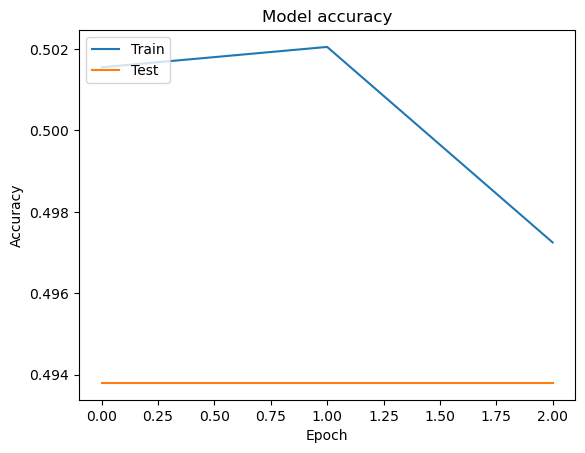

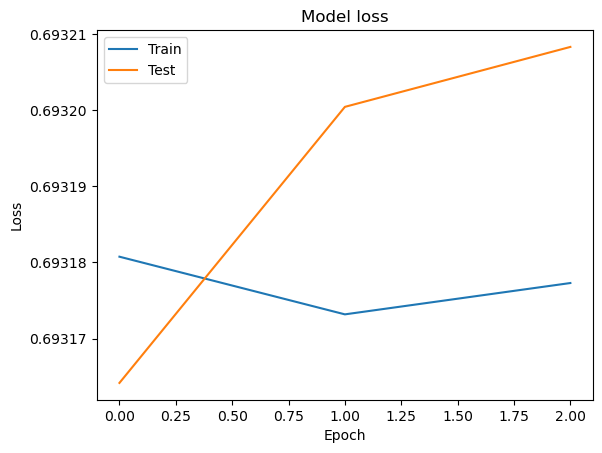

In [30]:
# Train the model
history = model.fit(X_train, y_train, batch_size=32, epochs=3, validation_split=0.2)
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}")
print(f"Test Accuracy: {accuracy}")
# Plot training & validation accuracy values
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [28]:

# Print the model summary
model.summary()

# Print the model architecture
from keras.utils import plot_model
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

### ^^^^^^^^^

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200)]             0         
                                                                 
 token_and_position_embeddin  (None, 200, 128)         2585600   
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer_block (Transfor  (None, 200, 128)         297344    
 merBlock)                                                       
                                                                 
 transformer_block_1 (Transf  (None, 200, 128)         297344    
 ormerBlock)                                                     
                                                                 
 transformer_block_2 (Transf  (None, 200, 128)         297344